In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas_bokeh
from bokeh.io import output_notebook, show
from bokeh.resources import INLINE
from bokeh.plotting import figure
output_notebook(INLINE)
# pandas_bokeh.output_notebook()

import gc, os, pickle, random, time, cmath, re
import geopy
from collections import Counter, defaultdict
from functools import partial
from pathlib import Path

from contextlib import contextmanager
import multiprocessing
import shap

from datetime import datetime
# import librosa
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.model_selection import cross_val_score,cross_val_predict

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.cluster import KMeans

from lightgbm import LGBMClassifier, LGBMRegressor
from category_encoders import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

/home/kevinco27/.local/lib/python3.5/site-packages/pandas_bokeh/__init__.py:24: Warning: Could not define plot method for Pandas DataFrame and Series. Please make sure that Pandas is installed if you wish to use Bokeh as plotting backend for Pandas. 

Exceptions: cannot import name 'CachedAccessor' 
  Warning,


Loading BokehJS ...

In [2]:
def load_df(dataset):
    if 'train' in dataset:
        df = pd.read_csv("../data/{}.csv".format(dataset))
    elif 'test' in dataset:
        df = pd.read_csv("../data/{}.csv".format(dataset))
    return df

print('Download Train and Test Data.\n')
with multiprocessing.Pool() as pool: 
    train, test = pool.map(load_df, ["train", "test"])

def attr_map(train, test):

    train['city'] = train['city'].map({3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
                                       17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'})
    test['city'] = test['city'].map({3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
                                       17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'})
    return train, test

# train, test = attr_map(train, test)

combine = pd.concat([train, test])
target = train['total_price']


Download Train and Test Data.



# 經緯度轉換

In [5]:
#(118.95, -37.46)
X1 = np.matrix([(117.2,-40.01), (119.66,-37.75), (118.95, -37.46)]) #(118.02,-37.93)])
X2 = np.matrix([(120.713287,21.987057), (121.775596, 25.142056), (120.499489, 24.214840)])
T = inv(X1.T * X1) * X1.T * X2
coor_trans_trn = np.matrix(train[['lon', 'lat']])*T
coor_trans_sub = np.matrix(test[['lon', 'lat']])*T
train['lon'] = np.array(coor_trans_trn[:,0]).squeeze()
train['lat'] = np.array(coor_trans_trn[:,1]).squeeze()

test['lon'] = np.array(coor_trans_sub[:,0]).squeeze()
test['lat'] = np.array(coor_trans_sub[:,1]).squeeze()

# Cluster Target Encode

In [6]:
class cluster_target_encoder:
    def __init__(self, nclusters = 4, seed=0):
        self.seed = seed
        self.nclusters = nclusters
        
    def make_encoding(self,df):
        self.encoding = df.groupby('X')['y'].mean()
        
    def fit(self,X,y):
        df = pd.DataFrame(columns=['X','y'], index=X.index)
        df['X'] = X
        df['y'] = y
        self.make_encoding(df)
        clust = KMeans(self.nclusters, random_state=self.seed)
        labels = clust.fit_predict(self.encoding[df['X'].values].values.reshape(-1,1))
        df['labels'] = labels
        self.clust_encoding = df.groupby('X')['labels'].median()
        
    def transform(self,X):
        res = X.map(self.clust_encoding).astype(float)
        return res
    def fit_transform(self,X,y):
        self.fit(X,y)
        return self.transform(X)

In [7]:
# village 2899
# 213
# 609
train['lonlat'] = train['lon'] + train['lat']
test['lonlat'] = test['lon'] + test['lat']
cate = 'lonlat'
X_train = train.drop(['total_price'],axis=1)
y_train = np.log1p(train['total_price'])

encoder = cluster_target_encoder(nclusters=2, seed=4)
labels_train = encoder.fit_transform(X_train[cate],train['total_price'])
labels_test = encoder.transform(test[cate])
est = LGBMClassifier()

est.fit(X_train.select_dtypes(include=[np.number]),labels_train)

labels_test[np.isnan(labels_test)] = est.predict(
    test.select_dtypes(include=[np.number]))[np.isnan(labels_test)]

train['labels'] = labels_train
test['labels'] = labels_test

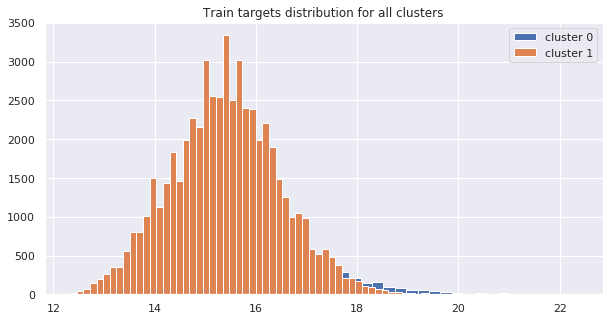

In [31]:
plt.figure(figsize=(10,5))
plt.hist(y_train.values[train['labels']==0],bins=40,label='cluster 0')
plt.hist(y_train.values[train['labels']==1],bins=70,label='cluster 1')
# plt.hist(y_train.values[train['labels']==2],bins=70,label='cluster 2')
# plt.hist(y_train.values[train['labels']==3],bins=70,label='cluster 3')
plt.legend()
plt.title('Train targets distribution for all clusters')
# plt.xlim((10,22))
plt.show()

In [8]:
# labels_test[np.isnan(labels_test)].shape
cross_val_score(
    X = X_train.select_dtypes(include=[np.number]),
    y = labels_train,
    estimator = LGBMClassifier(),
    cv = 5,
    scoring = 'roc_auc')

array([0.99912411, 0.99890737, 0.99993552, 0.9993532 , 0.99979575])

# Importance of Imbalanced Data

['total_price']
combine shape (70000, 237)
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's binary_logloss: 0.00535413	valid_0's auc: 0.999973
[2000]	valid_0's binary_logloss: 0.0014571	valid_0's auc: 0.999998
[3000]	valid_0's binary_logloss: 0.00104371	valid_0's auc: 0.999999
Early stopping, best iteration is:
[2893]	valid_0's binary_logloss: 0.00106215	valid_0's auc: 0.999999
Fold 1 RoC-AUC: 0.9999993957521376
234 234
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's binary_logloss: 0.00498505	valid_0's auc: 0.999993
[2000]	valid_0's binary_logloss: 0.00120749	valid_0's auc: 0.999998
Early stopping, best iteration is:
[2263]	valid_0's binary_logloss: 0.00105023	valid_0's auc: 0.999998
Fold 2 RoC-AUC: 0.9999984893803439
234 234
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's binary_logloss: 0.00545427	valid_0's auc: 0.999971
[2000]	valid_0's binary_logloss: 0.00125003	valid_0's auc: 0.999998
E

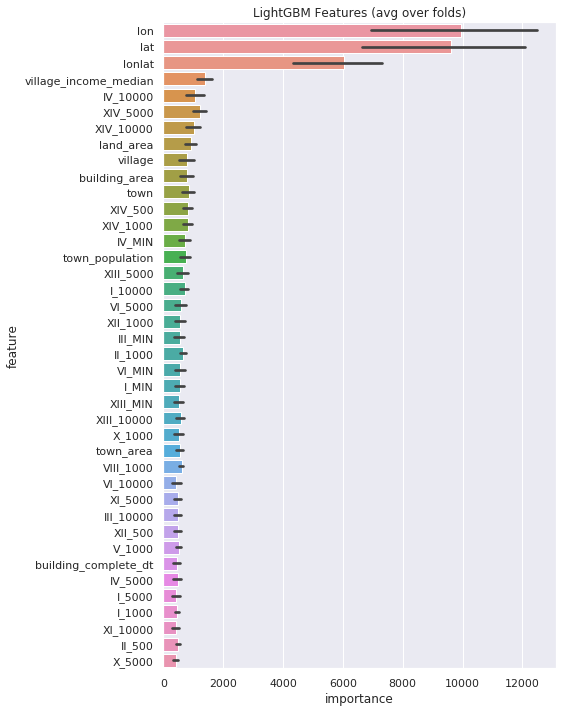

In [10]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('imbalanced.png')

def distribution_chceck(trn, sub,  folds):

    new_target = 'labels'
    
    combine = pd.concat([trn, sub])
    assert combine.shape[1] == sub.shape[1]
    combine.drop('building_id', axis=1 ,inplace=True)
    
    feats = [f for f in combine.columns if f not in ['building_id', new_target,'total_price']]
    X = combine[feats]
    y = combine[new_target]
    
    
    sss = StratifiedShuffleSplit(n_splits=folds, test_size=0.1, random_state=0)
    feature_importance_df = pd.DataFrame()
    oof_preds = np.zeros(combine.shape[0])
    
    for fold_, (train_index, test_index) in enumerate(sss.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = LGBMClassifier(n_estimators=100000,
                            learning_rate =  0.007,#0.003,
                            num_leaves=31,                
                            feature_fraction = 0.6, # sub_feature
                            bagging_fraction= 0.7, # subsample
                            silent=-1,
                            verbose=-1,
                            n_josb=-1)
        
        clf.fit(X_train, y_train, eval_set=[ (X_test, y_test )], 
                eval_metric = 'auc', verbose= 1000, early_stopping_rounds= 500)
        
        y_pred = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:,1]
        print('Fold {}'.format(fold_ + 1), 'RoC-AUC: {}'.format(roc_auc_score(y_test, y_pred)))
        fold_importance_df = pd.DataFrame()
        print(len(feats), len(clf.feature_importances_))
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
#         fold_importance_df["shap_values"] = abs(shap.TreeExplainer(clf).shap_values(valid_x)[:,:test_df.shape[1]]).mean(axis=0).T
        fold_importance_df["fold"] = fold_+ 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    display_importances(feature_importance_df)

distribution_chceck(train, test, folds=5)

# 建築物 category
- village 村里
- building_material 建材
- building_type 建物型態
- building_use 建物用途 (4,5 高價位多一個order)
- parking_way 車位停放方式

- 用這些數字(11/213/219/482)去類聚 lon/lat ～ Kmeans K
- lon ~ 231
- lat ~ 190
- lonlat ~ 609

## Missing Values
- parking_area               56897
- parking_price              46065
- txn_floor                  15902
- village_income_median       1142

## Date EDA
### 找出時間序列的相關因素

- txn_floor 交易樓層
- txn_dt 交易日期
- building_complete_dt 建物完成日期

## Target Encoding

In [11]:
# use target encoding to encode two categorical features

target_cate = ['lonlat']
target_num = ['total_price']
for i in target_cate:
    for j in target_num:
        enc = TargetEncoder(cols=[i]).fit(train[i], train[j])

        training_numeric_dataset = enc.transform(train[i], train[j])#.rename(cols={'city':'city_targ'})
        testing_numeric_dataset = enc.transform(test[i])

        training_numeric_dataset.rename(columns={i:i +'_targ_'+j}, inplace=True)
        testing_numeric_dataset.rename(columns={i:i +'_targ_'+j}, inplace=True)

        train[i +'_targ_' + j] = training_numeric_dataset
        test[i +'_targ_' + j] = testing_numeric_dataset
        del training_numeric_dataset, testing_numeric_dataset;
        gc.collect()

## Statistic Features Engineer

In [3]:
##################    UtilityFunction    #################
# nunique, mean, std, median, max, min, sum, var, quantile

def do_count( df, group_cols, agg_type='uint16', show_max=False, show_agg=True ):
    agg_name='{}count'.format('_'.join(group_cols))  
    if show_agg:
        print( "\nAggregating by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )
    
def do_countuniq( df, group_cols, counted, agg_type='uint8', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_countuniq'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCounting unqiue ", counted, " by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_cumcount( df, group_cols, counted,agg_type='uint16', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_cumcount'.format(('_'.join(group_cols)),(counted)) 
    if show_agg:
        print( "\nCumulative count by ", group_cols , '... and saved in', agg_name  )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_mean( df, group_cols, counted, agg_type='float16', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_mean'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCalculating mean of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_median( df, group_cols, counted, agg_type='float16', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_median'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCalculating median of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].median().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_max( df, group_cols, counted, agg_type='float16', show_agg=True ):
    agg_name= '{}_by_{}_max'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCalculating Max of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].max().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_min( df, group_cols, counted, agg_type='float16', show_agg=True ):
    agg_name= '{}_by_{}_min'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCalculating min of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].min().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_sum( df, group_cols, counted, agg_type='float16', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_sum'.format(('_'.join(group_cols)),(counted)) 
    if show_agg:
        print( "\nCalculating sum of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].sum().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_var( df, group_cols, counted, agg_type='float16', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_var'.format(('_'.join(group_cols)),(counted)) 
    if show_agg:
        print( "\nCalculating variance of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )


In [4]:
combine = pd.concat([train, test])

combine = do_sum( combine, ['village'], 'I_index_50'); gc.collect()
combine = do_sum( combine, ['village'], 'I_index_500'); gc.collect()
combine = do_sum( combine, ['village'], 'I_index_1000'); gc.collect()


combine = do_sum( combine, ['town'], 'I_index_50'); gc.collect()
combine = do_sum( combine, ['town'], 'I_index_500'); gc.collect()
combine = do_sum( combine, ['town'], 'I_index_1000'); gc.collect()

combine['town_I_index_50_sum_div_popu'] = combine['town_by_I_index_50_sum'] / combine['town_population']
combine['town_I_index_50_sum_div_area'] = combine['town_by_I_index_50_sum'] / combine['town_area']
combine['town_I_index_500_sum_div_popu'] = combine['town_by_I_index_500_sum'] / combine['town_population']
combine['town_I_index_500_sum_div_area'] = combine['town_by_I_index_500_sum'] / combine['town_area']

# 'town_population','town_area'


Calculating sum of  I_index_50  by  ['village'] ... and saved in village_by_I_index_50_sum

Calculating sum of  I_index_500  by  ['village'] ... and saved in village_by_I_index_500_sum

Calculating sum of  I_index_1000  by  ['village'] ... and saved in village_by_I_index_1000_sum

Calculating sum of  I_index_50  by  ['town'] ... and saved in town_by_I_index_50_sum

Calculating sum of  I_index_500  by  ['town'] ... and saved in town_by_I_index_500_sum

Calculating sum of  I_index_1000  by  ['town'] ... and saved in town_by_I_index_1000_sum


In [ ]:
# CATEGORY
# Geo: city, town, village
# Area: land_area, building_area

# NUMERICS
'''
village_income_median 所在里年收入中位數
town_population 所在鄉鎮市區人口數
town_area 所在鄉鎮市區面積
town_population_density 所在鄉鎮市區人口密度
'''


## Model Evaluation

In [5]:
train = combine[combine['total_price'].notnull()]
test = combine[combine['total_price'].isnull()]

def binary_error(preds, train_data):
    labels = train_data.get_label()
    return 'error', np.mean(labels != (preds > 0.5)), False

feval=lambda preds, train_data: [binary_error(preds, train_data),
                                                 accuracy(preds, train_data)],

In [ ]:
dt_today = datetime.today()

def display_shapley_values(feat_importance):
    best_features = feat_importance[["feature", "shap_values"]].groupby("feature")["shap_values"].agg(['mean', 'std']) \
                                                               .sort_values(by="mean", ascending=False).head(40).reset_index()
    best_features.columns = ["feature", "mean shapley values", "err"]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="mean shapley values", y="feature", xerr=best_features['err'], data=best_features)
    plt.title('LightGBM shapley values (avg over folds)')
    plt.savefig('./fig/lgbm_shap_{}.png'.format(dt_today.strftime("_%m_%d")))
    plt.tight_layout()
    plt.show()
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('./fig/lgbm_{}.png'.format(dt_today.strftime("_%m_%d")))
    
def hit_rate(y_true, y_pred):
    return np.mean(np.array([1 if i <= 0.1 else 0 for i in np.abs((y_pred - y_true)/y_true)]))

def Mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true)/y_true))

def score(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return (np.round(hit_rate(y_true, y_pred), 4)*1e4 + 1 - Mape(y_true, y_pred))

def model(trn, sub, folds):
    
    feats = [f for f in trn.columns if f not in ['building_id', 'total_price','lonlat']]
#     combine = pd.concat([trn[feats], sub[feats]])
    X = trn[feats]
    y = np.log1p(target)
    
    
    sss = KFold(n_splits=5,shuffle=True, random_state=0)
    feature_importance_df = pd.DataFrame()
    oof_preds = np.zeros(combine.shape[0])
    
    for fold_, (train_index, test_index) in enumerate(sss.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = LGBMRegressor(n_estimators=100000,
                            learning_rate =  0.009,#0.003,
                            num_leaves=31,                
                            feature_fraction = 0.6, # sub_feature
                            bagging_fraction= 0.7, # subsample
                            # lambda_l1 = 1
#                             bagging_freq= 5,
#                             min_data_in_leaf= 30,
#                             min_sum_hessian_in_leaf= 10,
#                             tree_learner='serial',
#                             boost_from_average='false',
                            silent=-1,
                            verbose=-1,
                            n_josb=-1)
        
        clf.fit(X_train, y_train, eval_set=[ (X_train, y_train),(X_test, y_test )], 
#                 eval_metric= 'mse', 
#                 categorical_feature  = ['lonlat'],
                verbose= 3000, early_stopping_rounds= 500)
        
        y_pred = np.expm1(clf.predict(X_test, num_iteration=clf.best_iteration_))
        print('Fold {}'.format(fold_ + 1), 'Hit-Rate plus MAPE: {}'.format(score(np.expm1(y_test), y_pred)),'\n')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
#         fold_importance_df["shap_values"] = abs(shap.TreeExplainer(clf).shap_values(X_test)[:,:sub[feats].shape[1]]).mean(axis=0).T
        fold_importance_df["fold"] = fold_+ 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    display_importances(feature_importance_df)
#     display_shapley_values(feature_importance_df)

model(train, test, folds=10)

Training until validation scores don't improve for 500 rounds.
[3000]	training's l2: 0.0315343	valid_1's l2: 0.049891
[6000]	training's l2: 0.0214957	valid_1's l2: 0.0451702
[9000]	training's l2: 0.0160716	valid_1's l2: 0.0431041
[12000]	training's l2: 0.0124699	valid_1's l2: 0.0419117
[15000]	training's l2: 0.00993012	valid_1's l2: 0.0411833
[18000]	training's l2: 0.00806712	valid_1's l2: 0.040697
[21000]	training's l2: 0.00664961	valid_1's l2: 0.0403276
[24000]	training's l2: 0.00553176	valid_1's l2: 0.0401052
[27000]	training's l2: 0.004651	valid_1's l2: 0.0399268
[30000]	training's l2: 0.00395669	valid_1's l2: 0.0397912
[33000]	training's l2: 0.00338332	valid_1's l2: 0.0396894
[36000]	training's l2: 0.00290884	valid_1's l2: 0.0396207
[39000]	training's l2: 0.00250861	valid_1's l2: 0.0395656
[42000]	training's l2: 0.00217971	valid_1's l2: 0.039518
[45000]	training's l2: 0.0019067	valid_1's l2: 0.039488
[48000]	training's l2: 0.00168251	valid_1's l2: 0.0394601
Early stopping, best it